In [0]:
import mlflow
mlflow.pyspark.ml.autolog()

In [0]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

schema = StructType([
    StructField("User_ID", IntegerType(), True),
    StructField("Game", StringType(), True),
    StructField("Behavior", StringType(), True),
    StructField("Hours_Played", DoubleType(), True)
])
# Load the dataset into a DataFrame with the defined schema
steam_df = spark.read.csv("dbfs:/FileStore/tables/steam_200k.csv", schema=schema)

In [0]:

# Generate unique IDs for games
game_ids_df = (steam_df
               .select("Game")
               .distinct()
               .withColumn("Game_ID", (monotonically_increasing_id())))

In [0]:
# Join the generated game IDs with the main DataFrame
steam_df = steam_df.join(game_ids_df, "Game", "left")
# Display the schema and first few rows of the DataFrame
steam_df.printSchema()
steam_df.show(5)

root
 |-- Game: string (nullable = true)
 |-- User_ID: integer (nullable = true)
 |-- Behavior: string (nullable = true)
 |-- Hours_Played: double (nullable = true)
 |-- Game_ID: long (nullable = true)

+--------------------+---------+--------+------------+-------+
|                Game|  User_ID|Behavior|Hours_Played|Game_ID|
+--------------------+---------+--------+------------+-------+
|The Elder Scrolls...|151603712|purchase|         1.0|   2609|
|The Elder Scrolls...|151603712|    play|       273.0|   2609|
|           Fallout 4|151603712|purchase|         1.0|    410|
|           Fallout 4|151603712|    play|        87.0|    410|
|               Spore|151603712|purchase|         1.0|   3868|
+--------------------+---------+--------+------------+-------+
only showing top 5 rows



In [0]:
# Filter out non-numeric values from specific columns
from pyspark.sql.functions import col

numeric_columns = [col_name for col_name, col_type in steam_df.dtypes if col_type != 'string']
steam_df_cleaned = steam_df.select(numeric_columns)

# Convert to Pandas DataFrame
pdf = steam_df_cleaned.toPandas()


In [0]:
pdf

,User_ID,Hours_Played,Game_ID
0,151603712,1.0,2609
1,151603712,273.0,2609
2,151603712,1.0,410
3,151603712,87.0,410
4,151603712,1.0,3868
...,...,...,...
199995,128470551,1.5,1821
199996,128470551,1.0,3415
199997,128470551,1.5,3415
199998,128470551,1.0,4392


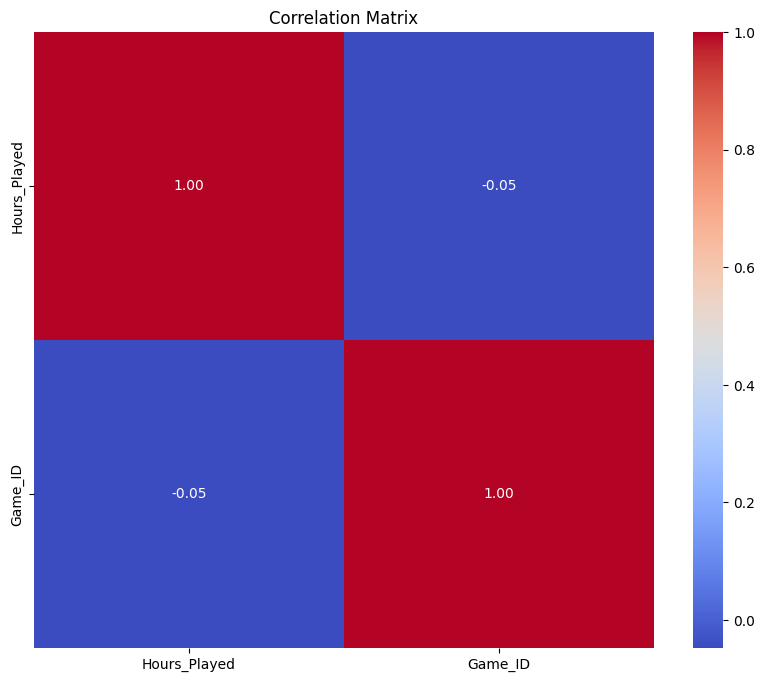

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `steam_df` is your DataFrame containing the data
# Convert Spark DataFrame to Pandas DataFrame
pdf = steam_df.toPandas()

# Drop non-numeric columns
numeric_columns = pdf.select_dtypes(include=['float64', 'int64']).columns
numeric_data = pdf[numeric_columns]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [0]:
# Preprocess the data
steam_play_df = steam_df.filter(col("Behavior") == "play")

In [0]:
# Split the data into training and test sets
(train_data, test_data) = steam_play_df.randomSplit([0.8, 0.2],seed=100)

In [0]:
# Train the collaborative filtering recommender system
als = ALS(maxIter=10, regParam=0.1, userCol="User_ID", itemCol="Game_ID", ratingCol="Hours_Played", coldStartStrategy="drop")
model = als.fit(train_data)

# Evaluate the model
predictions = model.transform(train_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

2024/04/27 17:30:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3dff4346b58f42d890ee82df188fec55', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/27 17:30:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

Root Mean Squared Error (RMSE): 19.683320954949107


In [0]:
predictions.display()

Game,User_ID,Behavior,Hours_Played,Game_ID,prediction
007 Legends,46055854,play,0.7,403,0.7878592
0RBITALIS,86055705,play,0.3,2726,0.28917247
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),49893565,play,2.4,657,3.8082888
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),78560022,play,0.2,657,0.2464714
"10,000,000",33865373,play,3.6,3112,3.6010365
100% Orange Juice,48028873,play,1.8,275,0.98940605
100% Orange Juice,88525821,play,0.9,275,0.6128017
100% Orange Juice,93644606,play,3.1,275,2.6341994
100% Orange Juice,125017535,play,0.7,275,0.2955866
1000 Amps,55426012,play,0.1,1349,0.103375494


In [0]:
#Extra Analysis with test_data
 
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Define different hyperparameter configurations
hyperparameters = [
    {'maxIter': 5, 'regParam': 0.01},
    {'maxIter': 10, 'regParam': 0.1},
    {'maxIter': 20, 'regParam': 0.5}
    # Add more configurations as needed
]

best_rmse = float('inf')  # Initialize best RMSE to infinity
best_model = None  # Initialize best model to None

for params in hyperparameters:
    # Train the collaborative filtering recommender system
    als = ALS(**params, userCol="User_ID", itemCol="Game_ID", ratingCol="Hours_Played", coldStartStrategy="drop")
    model = als.fit(test_data)

    # Evaluate the model
    predictions = model.transform(test_data)  # Use test data for evaluation
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    
    print("Hyperparameters:", params)
    print("Root Mean Squared Error (RMSE):", rmse)
    
    # Update best model if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

print("Best Model RMSE:", best_rmse)


2024/04/27 17:31:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd81f5278234349e9af7cc93b5c051e93', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/27 17:31:37 WARNING mlflow.pyspark.ml: Model ALS_b11704d6c0cd will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Hyperparameters: {'maxIter': 5, 'regParam': 0.01}
Root Mean Squared Error (RMSE): 1.6049451881777674


2024/04/27 17:31:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1c96a4cbec924a7598f716c4963d5692', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/27 17:32:23 WARNING mlflow.pyspark.ml: Model ALS_3970345c3db3 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Hyperparameters: {'maxIter': 10, 'regParam': 0.1}
Root Mean Squared Error (RMSE): 0.9403084609460235


2024/04/27 17:32:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd674e2d5ef484afba98a4ce684dc4e95', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/27 17:34:15 WARNING mlflow.pyspark.ml: Model ALS_8b319e1f6526 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Hyperparameters: {'maxIter': 20, 'regParam': 0.5}
Root Mean Squared Error (RMSE): 1.6556559496289995
Best Model RMSE: 0.9403084609460235
